In [1]:
%pylab inline
import numpy as np
from scipy.special import erf
from time import time
import datetime
from SparseARD import *

retrain = False
results_file = './saved_results/VI_MAP_100_5.npy'
np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
alpha = 5

log_kappa_min = 0
log_kappa_max = 8
n_kappas = 17

log_sigma_min = -2
log_sigma_max = -1
n_sigmas = 2

n_trials = 1000
estimate_sigma = False
maxit=1500

# Note m>=n for features to be orthogonal
n = 100
m = 100
s = 25

kappas = np.logspace(log_kappa_min, log_kappa_max, n_kappas)
sigmas = np.logspace(log_sigma_min, log_sigma_max, n_sigmas)

In [3]:
if retrain:

    Added = {}
    Missed = {}

    for method in ['VI', 'MAP']:

        Added[method] = [np.zeros((n_trials, n_kappas)) for _ in range(n_sigmas)]
        Missed[method] = [np.zeros((n_trials, n_kappas)) for _ in range(n_sigmas)]

    start_time = time()

    for trial in range(n_trials):

        for i in range(n_kappas):

            kappa = kappas[i]

            # Get random matrix Theta with cond(Theta)=kappa
            S = np.diag(np.linspace(kappa**-1, 1, np.min([n,m])))
            A = np.random.randn(m,n)
            U,_,Vt = np.linalg.svd(A, full_matrices = False)
            Theta = U.dot(S).dot(Vt)

            # Random sparse vector
            xi = np.zeros((n,1))
            xi[:s] = np.random.randn(s,1)

            for j in range(n_sigmas):

                if i==0 and j==0 and trial == 0:
                    print('Trial', trial+1, 'of', str(n_trials)+'.  kappa', i+1, 'of', \
                          str(n_kappas)+'. sigma', j+1, 'of', n_sigmas)
                else:
                    """
                    Prints out expected remaining time, but not very accurate since tests
                    with higher condition number tendto take longer.
                    """
                    ellapsed_time = time()-start_time
                    tests_completed = trial*n_kappas*n_sigmas + i*n_sigmas + j
                    tests_remaining = n_trials*n_kappas*n_sigmas - tests_completed
                    ETA = int(tests_remaining*ellapsed_time/tests_completed)
                    print('Trial', trial+1, 'of', str(n_trials)+'.  kappa', i+1, 'of', \
                          str(n_kappas)+'. sigma', j+1, 'of', str(n_sigmas)+'. ETA:', \
                          str(datetime.timedelta(seconds=ETA)))

                sigma = sigmas[j]
                y = Theta.dot(xi) + sigma*np.random.randn(m,1)

                #####################################################################

                # Learn with ARD-VI
                xi_hat = SBL([Theta,y], alpha=alpha, sigma2=sigma**2, verbose=False, \
                             estimate_sigma = estimate_sigma, maxit=maxit)[2]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['VI'][j][trial,i] = added
                Missed['VI'][j][trial,i] = missed

                #####################################################################

                # Learn with MAP-STSBL using tau_MAP = (alpha-1)/2
                xi_hat = MAP_STSBL(Theta, y, (alpha-1)/2, sigma2=sigma**2, maxit=maxit, \
                                   estimate_sigma=estimate_sigma,verbose=False)[0]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['MAP'][j][trial,i] = added
                Missed['MAP'][j][trial,i] = missed
                
    # Save results
    results = {'Added': Added, \
               'Missed': Missed}
    np.save(results_file, results)
    
else:
    results = np.load(results_file, allow_pickle=True).item()
    Added = results['Added']    
    Missed = results['Missed']

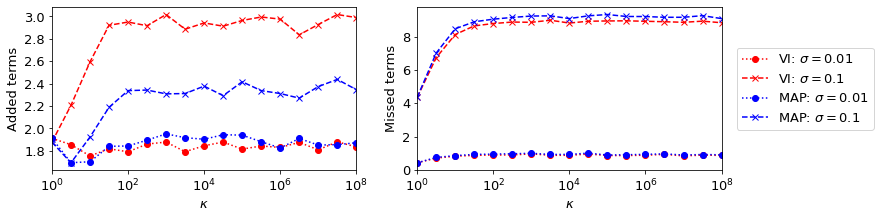

In [4]:
figure(figsize = (12,3))
fontsize = 13

colors = ['r', 'b']
linestyles = ['dotted', 'dashed']
markertypes = ['o', 'x']

################################################################################
subplot(1,2,1)

for i in range(len(Added.keys())):
    method = list(Added.keys())[i]
    for j in range(n_sigmas):        
        plot(kappas, Added[method][j].mean(0), colors[i], linestyle=linestyles[j], \
             label=r'$\sigma=$'+str(sigmas[j]), marker=markertypes[j])

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\kappa$', fontsize=fontsize)
xlim(kappas[0],kappas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

################################################################################
subplot(1,2,2)

for i in range(len(Missed.keys())):
    method = list(Missed.keys())[i]
    for j in range(n_sigmas):        
        plot(kappas, Missed[method][j].mean(0), colors[i], linestyle=linestyles[j], \
             label=method+r': $\sigma=$'+str(sigmas[j]), marker=markertypes[j])

xscale('log')
ylabel('Missed terms', fontsize=fontsize)
xlabel(r'$\kappa$', fontsize=fontsize)
xlim(kappas[0],kappas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
legend(fontsize = fontsize, bbox_to_anchor=(1.05, 0.75), \
       loc='upper left', borderaxespad=0.)